# Assignment I: The Aiygari Model

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Test 1: Solving and simulating the household problem](#toc2_)    
- 3. [Test 2: Evaluating the objective for finding the steady state](#toc3_)    
- 4. [Find stationary equilibrium](#toc4_)    
- 5. [Grid search](#toc5_)    
- 6. [Policy functions](#toc6_)    
- 7. [Simulation](#toc7_)    
- 8. [Changing the tax rates](#toc8_)    
- 9. [Adding a transfer](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 

from HANCModel import HANCModelClass
from steady_state import obj_ss

## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [2]:
model = HANCModelClass(name='baseline')

In [3]:
par = model.par
ss = model.ss

## 2. <a id='toc2_'></a>[Test 1: Solving and simulating the household problem](#toc0_)

We set all the steady values for the household problem manually at ad hoc values:

In [4]:
ss.rt = 0.02*(1-0.1)
ss.wt = 1.00*(1-0.3)
ss.transfer = 0.0

We can now solve and simulate:

In [5]:
model.solve_hh_ss(do_print=True)

household problem in ss solved in 3.2 secs [350 iterations]


In [6]:
model.simulate_hh_ss(do_print=True)

household problem in ss simulated in 4.4 secs [399 iterations]


And we can check whether the results make sort of sense:

In [7]:
print(f'{model.ss.A_hh = :.2f}')
print(f'{model.ss.C_hh = :.2f}')
print(f'{model.ss.L_hh = :.2f}')

model.ss.A_hh = 2.04
model.ss.C_hh = 0.78
model.ss.L_hh = 1.07


## 3. <a id='toc3_'></a>[Test 2: Evaluating the objective for finding the steady state](#toc0_)

We can try out various inputs and look at the outputs:

In [8]:
for KL in [2.0,3.0,4.0]:
    clearing_A = obj_ss(KL,model,do_print=False)
    print(f'{KL = :.2f} -> {clearing_A = :12.8f}')

KL = 2.00 -> clearing_A = -94.91822380
KL = 3.00 -> clearing_A = -10.21105172
KL = 4.00 -> clearing_A =   5.88602412


## 4. <a id='toc4_'></a>[Find stationary equilibrium](#toc0_)

In [9]:
model.find_ss(do_print=True)

seaching in [2.9308,4.7940]
steady state found in 4.8 secs
ss.K =  3.421
ss.B =  0.631
ss.A_hh =  4.052
ss.L =  1.012
ss.Y =  1.459
ss.r =  0.028
ss.w =  1.009
ss.clearing_A = 7.82e-13
ss.clearing_N = 0.00e+00
ss.clearing_Y = 1.59e-10


## 5. <a id='toc5_'></a>[Grid search](#toc0_)

In [10]:
par.tau_a_ss = 0.0
KL_min = ((1/par.beta+par.delta-1)/(par.alpha*par.Gamma))**(1/(par.alpha-1))
KL_max = (par.delta/(par.alpha*par.Gamma))**(1/(par.alpha-1))

In [11]:
NKL = 10
KL_vec = np.hstack((np.linspace(KL_min+1e-2,KL_max-1e-2,NKL),np.linspace(KL_max+1e-2,10.0,NKL)))
clearing_A_vec = np.nan*np.ones(KL_vec.size)
r_vec = np.nan*np.ones(KL_vec.size)

model_ = model.copy()
for i,KL in enumerate(KL_vec):
    print(f'{KL = :6.2f}: ',end='')
    try:
        clearing_A_vec[i] = obj_ss(KL,model_,do_print=False)
        r_vec[i] = model_.ss.r
        print(f'clearing_A = {clearing_A_vec[i]:16.8f}')
    except Exception as e:
        print(e)

KL =   2.93: clearing_A =     -54.02435484
KL =   3.14: clearing_A =     -10.76233594
KL =   3.34: clearing_A =      -3.03571273
KL =   3.55: clearing_A =       0.73000184
KL =   3.76: clearing_A =       3.16122400
KL =   3.97: clearing_A =       5.17768256
KL =   4.17: clearing_A =       7.40461443
KL =   4.38: clearing_A =      10.84402205
KL =   4.59: clearing_A =      19.63726937
KL =   4.79: clearing_A =     374.22446561
KL =   4.81: clearing_A =    -368.42276685
KL =   5.39: clearing_A =      -2.66327694
KL =   5.97: clearing_A =       1.07738382
KL =   6.54: clearing_A =       2.67872324
KL =   7.12: clearing_A =       3.72441818
KL =   7.70: clearing_A =       4.54242487
KL =   8.27: clearing_A =       5.24424190
KL =   8.85: clearing_A =       5.88007152
KL =   9.42: clearing_A =       6.47455559
KL =  10.00: clearing_A =       7.04097314


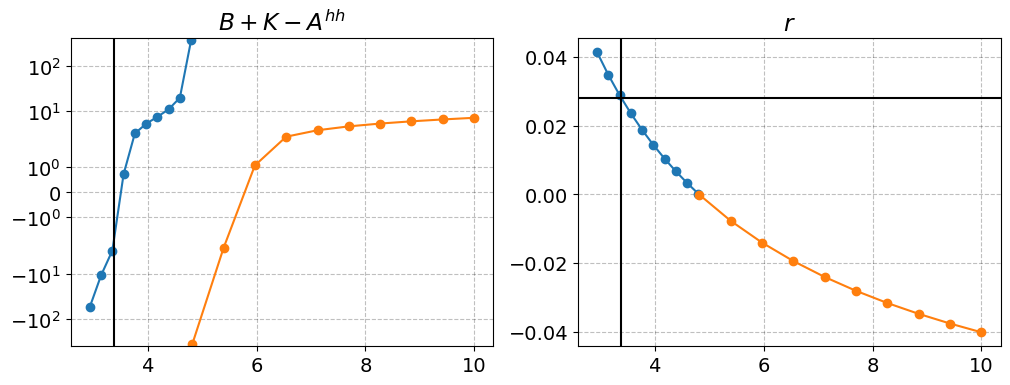

In [12]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('$B+K-A^{hh}$')
ax.plot(KL_vec[:NKL],clearing_A_vec[:NKL],'-o')
ax.plot(KL_vec[NKL:],clearing_A_vec[NKL:],'-o')
ax.axvline(ss.K/ss.L,color='black')
ax.set_yscale('symlog')

ax = fig.add_subplot(1,2,2)
ax.set_title('$r$')
ax.plot(KL_vec[:NKL],r_vec[:NKL],'-o')
ax.plot(KL_vec[NKL:],r_vec[NKL:],'-o')
ax.axvline(ss.K/ss.L,color='black');
ax.axhline(ss.r,color='black');

In [13]:
model_.find_ss(KL_max+1e-4,10.0,do_print=True)

seaching in [4.8041,10.0000]
steady state found in 1.7 secs
ss.K =  5.927
ss.B = -5.791
ss.A_hh =  0.136
ss.L =  1.035
ss.Y =  1.747
ss.r = -0.012
ss.w =  1.182
ss.clearing_A = -1.68e-14
ss.clearing_N = 0.00e+00
ss.clearing_Y = 1.15e-11


## 6. <a id='toc6_'></a>[Policy functions](#toc0_)

par.zeta_grid[i_fix] = 0.9, par.varphi_grid[i_fix] = 0.9


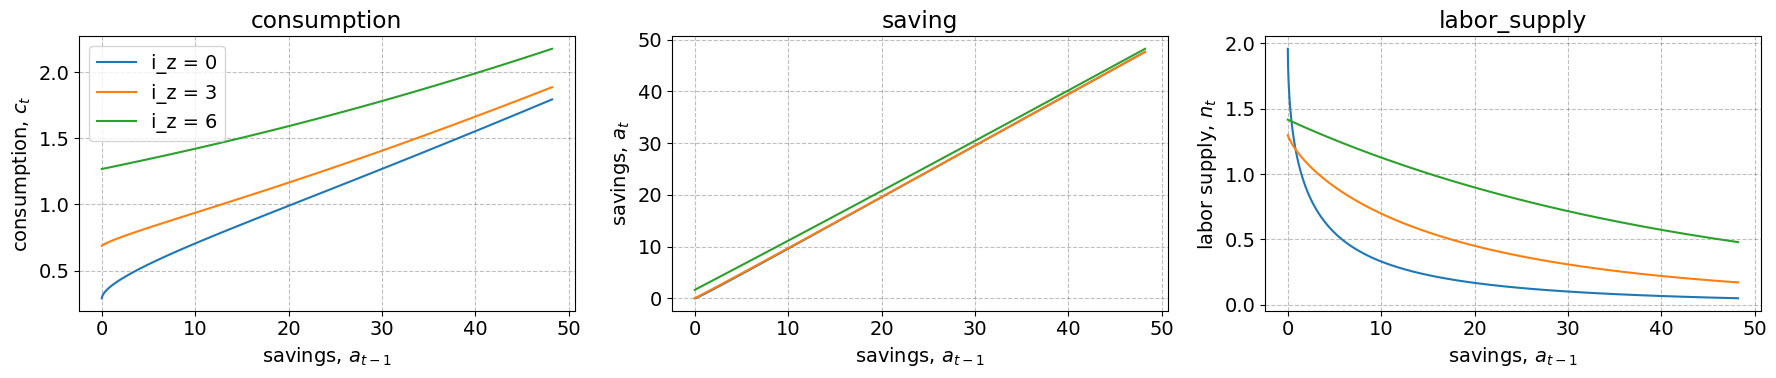

par.zeta_grid[i_fix] = 1.1, par.varphi_grid[i_fix] = 0.9


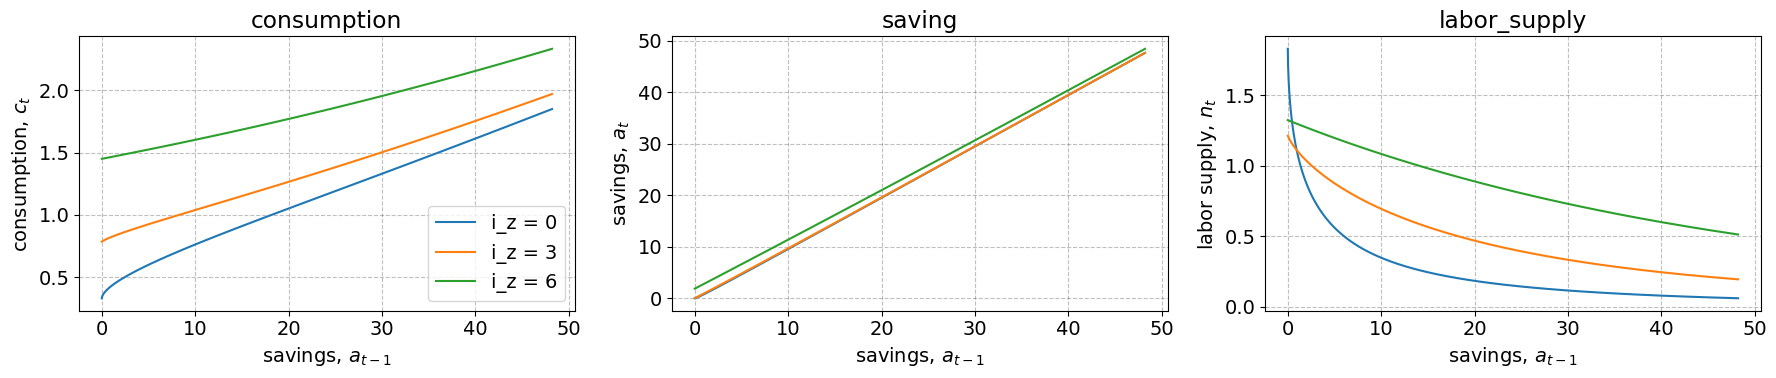

par.zeta_grid[i_fix] = 0.9, par.varphi_grid[i_fix] = 1.1


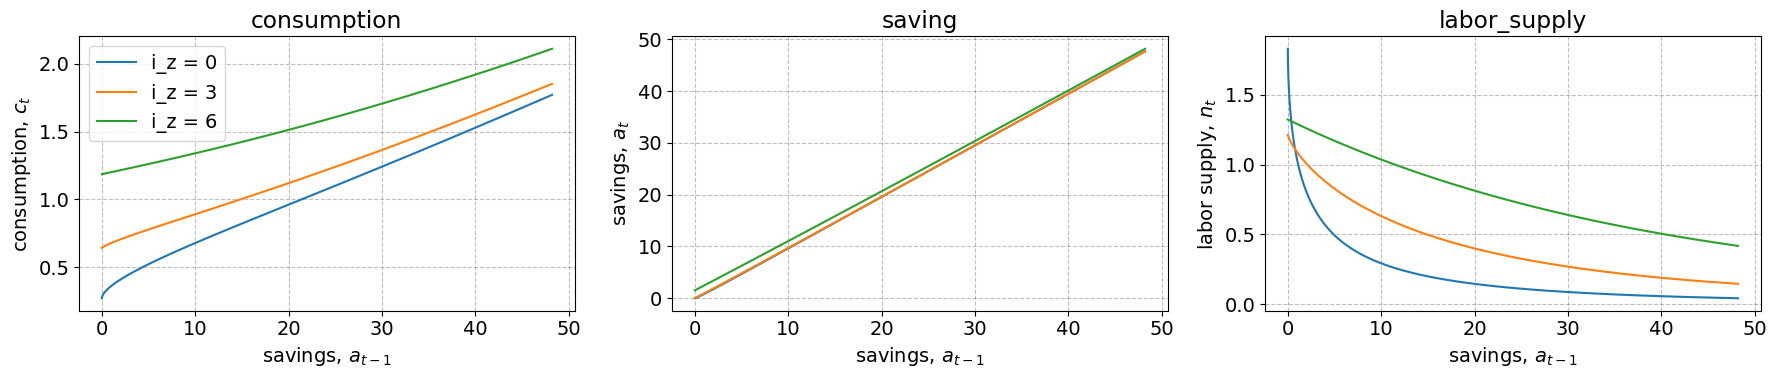

par.zeta_grid[i_fix] = 1.1, par.varphi_grid[i_fix] = 1.1


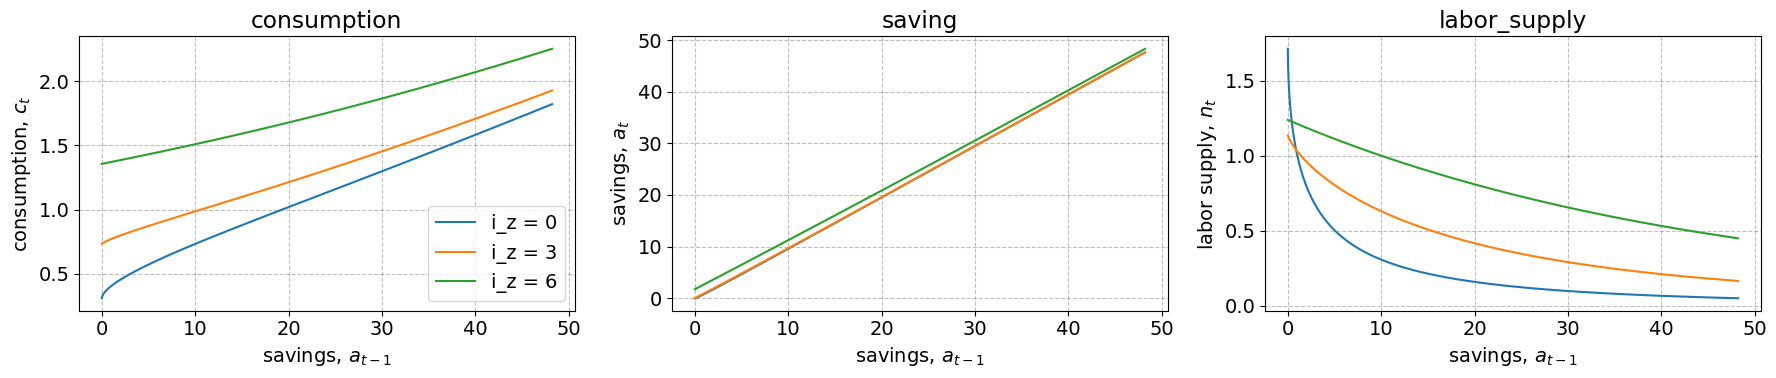

In [14]:
for i_fix in range(par.Nfix):
    
    print(f'{par.zeta_grid[i_fix] = :.1f}, {par.varphi_grid[i_fix] = :.1f}')
    
    fig = plt.figure(figsize=(18,4),dpi=100)
    a_max = 50

    # a. consumption
    I = par.a_grid < a_max

    ax = fig.add_subplot(1,3,1)
    ax.set_title(f'consumption')

    for i_z in [0,par.Nz//2,par.Nz-1]:
        ax.plot(par.a_grid[I],ss.c[i_fix,i_z,I],label=f'i_z = {i_z}')

    ax.legend(frameon=True)
    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('consumption, $c_t$')

    # b. saving
    I = par.a_grid < a_max

    ax = fig.add_subplot(1,3,2)
    ax.set_title(f'saving')

    for i_z in [0,par.Nz//2,par.Nz-1]:
        ax.plot(par.a_grid[I],ss.a[i_fix,i_z,I],label=f'i_z = {i_z}')

    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('savings, $a_{t}$')

    # c. labor supply
    I = par.a_grid < a_max

    ax = fig.add_subplot(1,3,3)
    ax.set_title(f'labor_supply')

    for i_z in [0,par.Nz//2,par.Nz-1]:
        ax.plot(par.a_grid[I],ss.ell[i_fix,i_z,I],label=f'i_z = {i_z}')

    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('labor supply, $n_{t}$')

    fig.tight_layout()
    plt.show()

## 7. <a id='toc7_'></a>[Simulation](#toc0_)

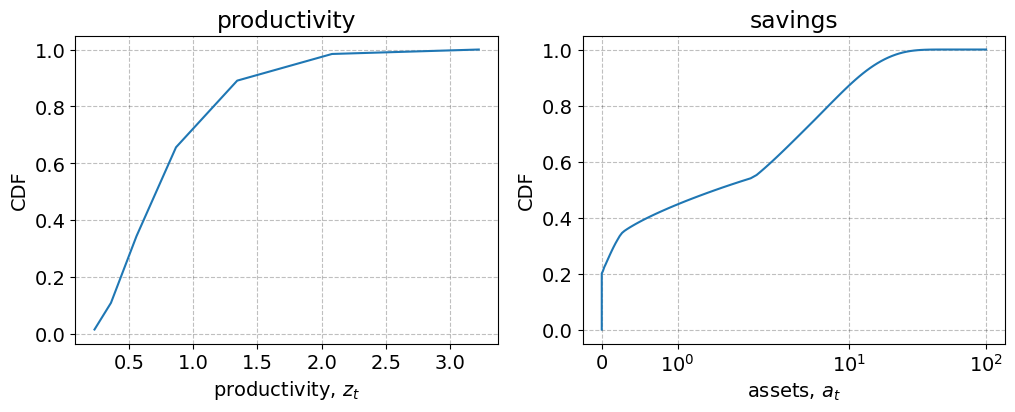

In [15]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')

y = np.cumsum(np.sum(ss.D,axis=(0,2)))
ax.plot(par.z_grid,y/y[-1])

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
y = np.insert(np.cumsum(np.sum(ss.D,axis=(0,1))),0,0.0)
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
        
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

## 8. <a id='toc8_'></a>[Changing the tax rates](#toc0_)

We now vary the tax rates, find the stationary equilibrium, and calculate household welfare.

In [16]:
tau_a_vec = [0.0,0.1,0.2]
tau_ell_vec = np.linspace(0.20,0.30,10)

models = {}
for tau_a in tau_a_vec:
    for tau_ell in tau_ell_vec:
        
        print(f'{tau_a = :.2f}, {tau_ell = :.2f}: ',end='')
        
        model_ = model.copy()
        model_.par.tau_a_ss = tau_a
        model_.par.tau_ell_ss = tau_ell
        
        try:
            model_.find_ss()
            models[(tau_a,tau_ell)] = model_
            print('completed')
        except Exception as e:
            print(f'{e}')
    
    print('')

tau_a = 0.00, tau_ell = 0.20: f(a) and f(b) must have different signs
tau_a = 0.00, tau_ell = 0.21: f(a) and f(b) must have different signs
tau_a = 0.00, tau_ell = 0.22: f(a) and f(b) must have different signs
tau_a = 0.00, tau_ell = 0.23: f(a) and f(b) must have different signs
tau_a = 0.00, tau_ell = 0.24: f(a) and f(b) must have different signs
tau_a = 0.00, tau_ell = 0.26: f(a) and f(b) must have different signs
tau_a = 0.00, tau_ell = 0.27: completed
tau_a = 0.00, tau_ell = 0.28: completed
tau_a = 0.00, tau_ell = 0.29: completed
tau_a = 0.00, tau_ell = 0.30: completed

tau_a = 0.10, tau_ell = 0.20: f(a) and f(b) must have different signs
tau_a = 0.10, tau_ell = 0.21: f(a) and f(b) must have different signs
tau_a = 0.10, tau_ell = 0.22: f(a) and f(b) must have different signs
tau_a = 0.10, tau_ell = 0.23: f(a) and f(b) must have different signs
tau_a = 0.10, tau_ell = 0.24: f(a) and f(b) must have different signs
tau_a = 0.10, tau_ell = 0.26: f(a) and f(b) must have different signs

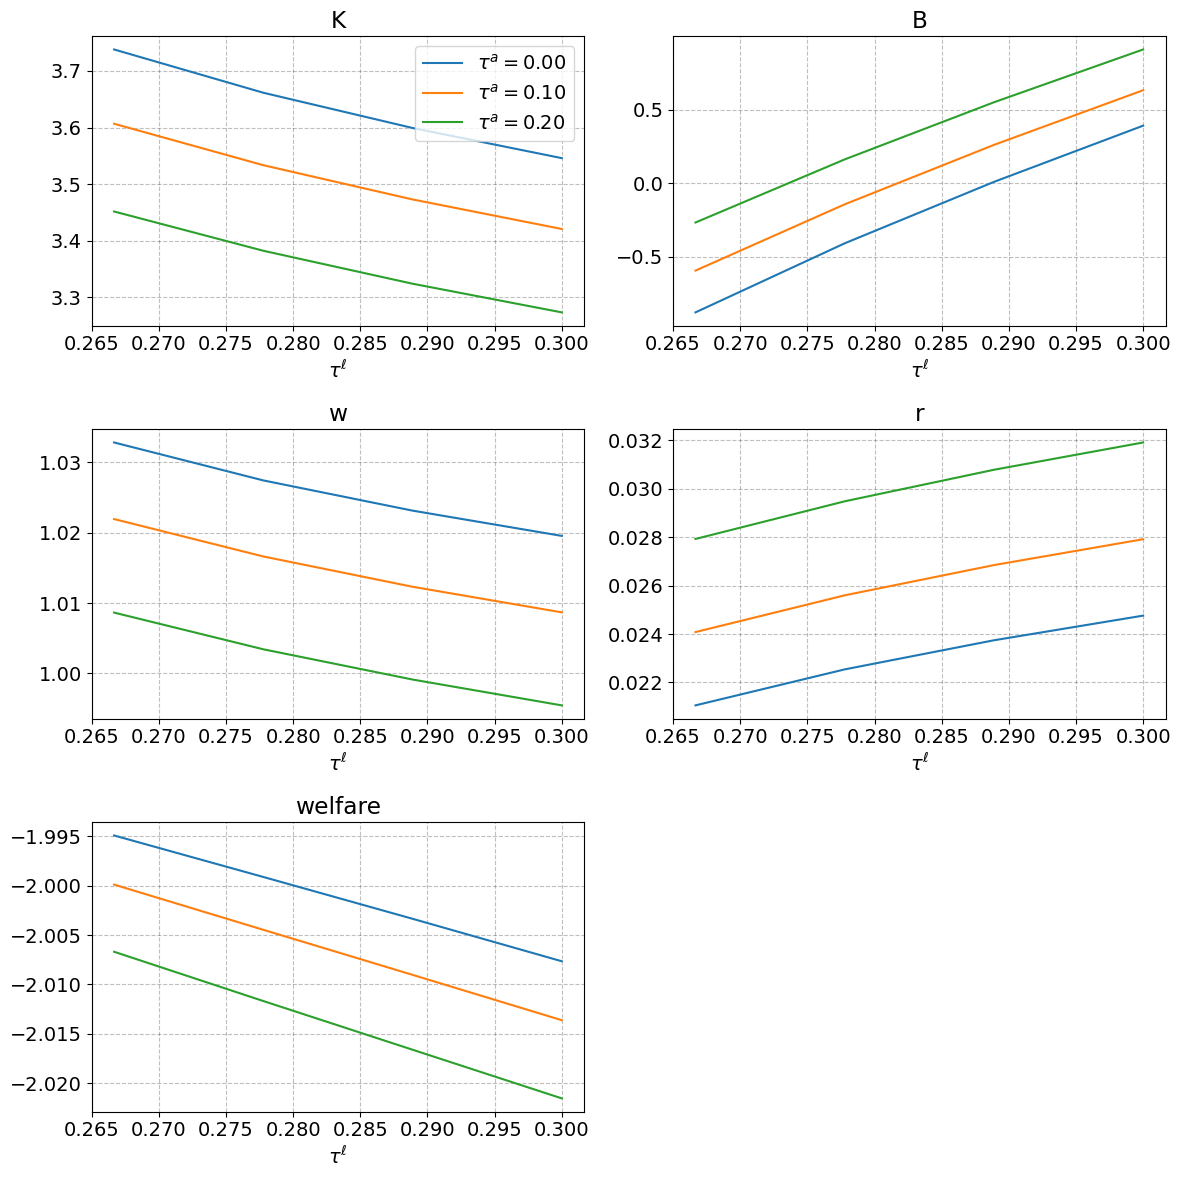

In [17]:
fig = plt.figure(figsize=(12,12),dpi=100)

# a. income
ax1 = fig.add_subplot(3,2,1)
ax1.set_title('K')

ax2 = fig.add_subplot(3,2,2)
ax2.set_title('B')

ax3 = fig.add_subplot(3,2,3)
ax3.set_title('w')

ax4 = fig.add_subplot(3,2,4)
ax4.set_title('r')

ax5 = fig.add_subplot(3,2,5)
ax5.set_title('welfare')

for tau_a in tau_a_vec:
    
    x = []
    y1 = []
    y2 = []
    y3 = []
    y4 = []
    y5 = []
    
    for tau_ell in tau_ell_vec:
        key = (tau_a,tau_ell)
        if key in models:
            x.append(tau_ell)    
            y1.append(models[key].ss.K)
            y2.append(models[key].ss.B)
            y3.append(models[key].ss.w)
            y4.append(models[key].ss.r)
            y5.append(models[key].ss.U_hh)
            
    if len(y1) > 0: ax1.plot(x,y1,label=f'$\\tau^a = {tau_a:.2f}$')
    if len(y2) > 0: ax2.plot(x,y2,label=f'$\\tau^a = {tau_a:.2f}$')
    if len(y3) > 0: ax3.plot(x,y3,label=f'$\\tau^a = {tau_a:.2f}$')       
    if len(y4) > 0: ax4.plot(x,y4,label=f'$\\tau^a = {tau_a:.2f}$')
    if len(y5) > 0: ax5.plot(x,y5,label=f'$\\tau^a = {tau_a:.2f}$')
    
for ax in [ax1,ax2,ax3,ax4,ax5]:
    ax.set_xlabel('$\\tau^{\ell}$')
        
ax1.legend(frameon=True)
fig.tight_layout()

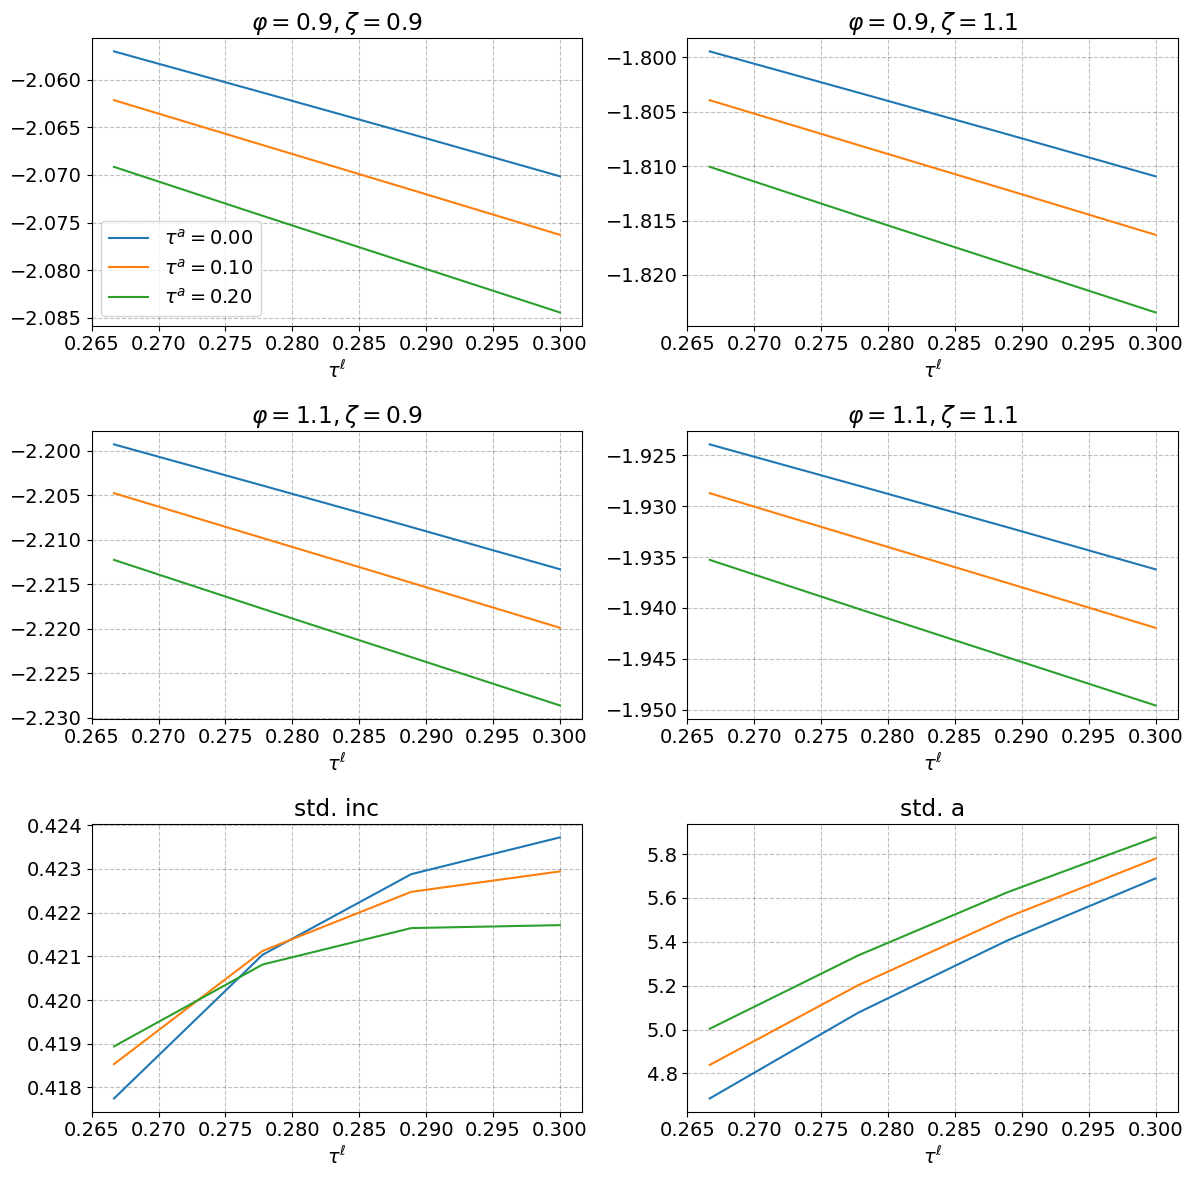

In [18]:
fig = plt.figure(figsize=(12,12),dpi=100)

axs = []
for i_fix in range(par.Nfix+2):

    ax = fig.add_subplot(3,2,1+i_fix)
    
    if i_fix == par.Nfix:
        ax.set_title(f'std. inc')
    elif i_fix == par.Nfix+1:
        ax.set_title(f'std. a')
    else:
        ax.set_title(f'$\\varphi = {par.varphi_grid[i_fix]}, \\zeta = {par.zeta_grid[i_fix]}$')

    axs.append(ax)

for tau_a in tau_a_vec:
    
    x = []
    
    y1 = []
    y2 = []
    y3 = []
    y4 = []
    y5 = []
    y6 = []
    
    for tau_ell in tau_ell_vec:
        key = (tau_a,tau_ell)
        if key in models:
            x.append(tau_ell)    
            y1.append(models[key].ss.U_hh_0)
            y2.append(models[key].ss.U_hh_1)
            y3.append(models[key].ss.U_hh_2)
            y4.append(models[key].ss.U_hh_3)
            y5.append(models[key].ss.std_inc)
            y6.append(models[key].ss.std_a)
            
    if len(y1) > 0: axs[0].plot(x,y1,label=f'$\\tau^a = {tau_a:.2f}$')
    if len(y2) > 0: axs[1].plot(x,y2,label=f'$\\tau^a = {tau_a:.2f}$')
    if len(y3) > 0: axs[2].plot(x,y3,label=f'$\\tau^a = {tau_a:.2f}$')       
    if len(y4) > 0: axs[3].plot(x,y4,label=f'$\\tau^a = {tau_a:.2f}$')
    if len(y5) > 0: axs[4].plot(x,y5,label=f'$\\tau^a = {tau_a:.2f}$')
    if len(y6) > 0: axs[5].plot(x,y6,label=f'$\\tau^a = {tau_a:.2f}$')
    
for ax in axs:
    ax.set_xlabel('$\\tau^{\ell}$')
        
axs[0].legend(frameon=True)
fig.tight_layout()

## 9. <a id='toc9_'></a>[Adding a transfer](#toc0_)

We make a transfer only to the poorest income group. This improves average welfare.

In [19]:
transfer_vec = [0.0,0.05,0.1]

models_transfers = {}
model_ = model.copy()
for transfer in transfer_vec:
    for tau_ell in tau_ell_vec:
        
        print(f'{transfer = :.2f}, {tau_ell = :.2f}: ',end='')

        model_.par.transfer_ss = transfer
        model_.par.tau_ell_ss = tau_ell
        
        try:
            model_.find_ss()
            models_transfers[(transfer,tau_ell)] = model_.copy()
            print('completed')
        except Exception as e:
            print(f'{e}')
            
    print('')

transfer = 0.00, tau_ell = 0.20: f(a) and f(b) must have different signs
transfer = 0.00, tau_ell = 0.21: f(a) and f(b) must have different signs
transfer = 0.00, tau_ell = 0.22: f(a) and f(b) must have different signs
transfer = 0.00, tau_ell = 0.23: f(a) and f(b) must have different signs
transfer = 0.00, tau_ell = 0.24: f(a) and f(b) must have different signs
transfer = 0.00, tau_ell = 0.26: f(a) and f(b) must have different signs
transfer = 0.00, tau_ell = 0.27: completed
transfer = 0.00, tau_ell = 0.28: completed
transfer = 0.00, tau_ell = 0.29: completed
transfer = 0.00, tau_ell = 0.30: completed

transfer = 0.05, tau_ell = 0.20: f(a) and f(b) must have different signs
transfer = 0.05, tau_ell = 0.21: f(a) and f(b) must have different signs
transfer = 0.05, tau_ell = 0.22: f(a) and f(b) must have different signs
transfer = 0.05, tau_ell = 0.23: f(a) and f(b) must have different signs
transfer = 0.05, tau_ell = 0.24: f(a) and f(b) must have different signs
transfer = 0.05, tau_ell

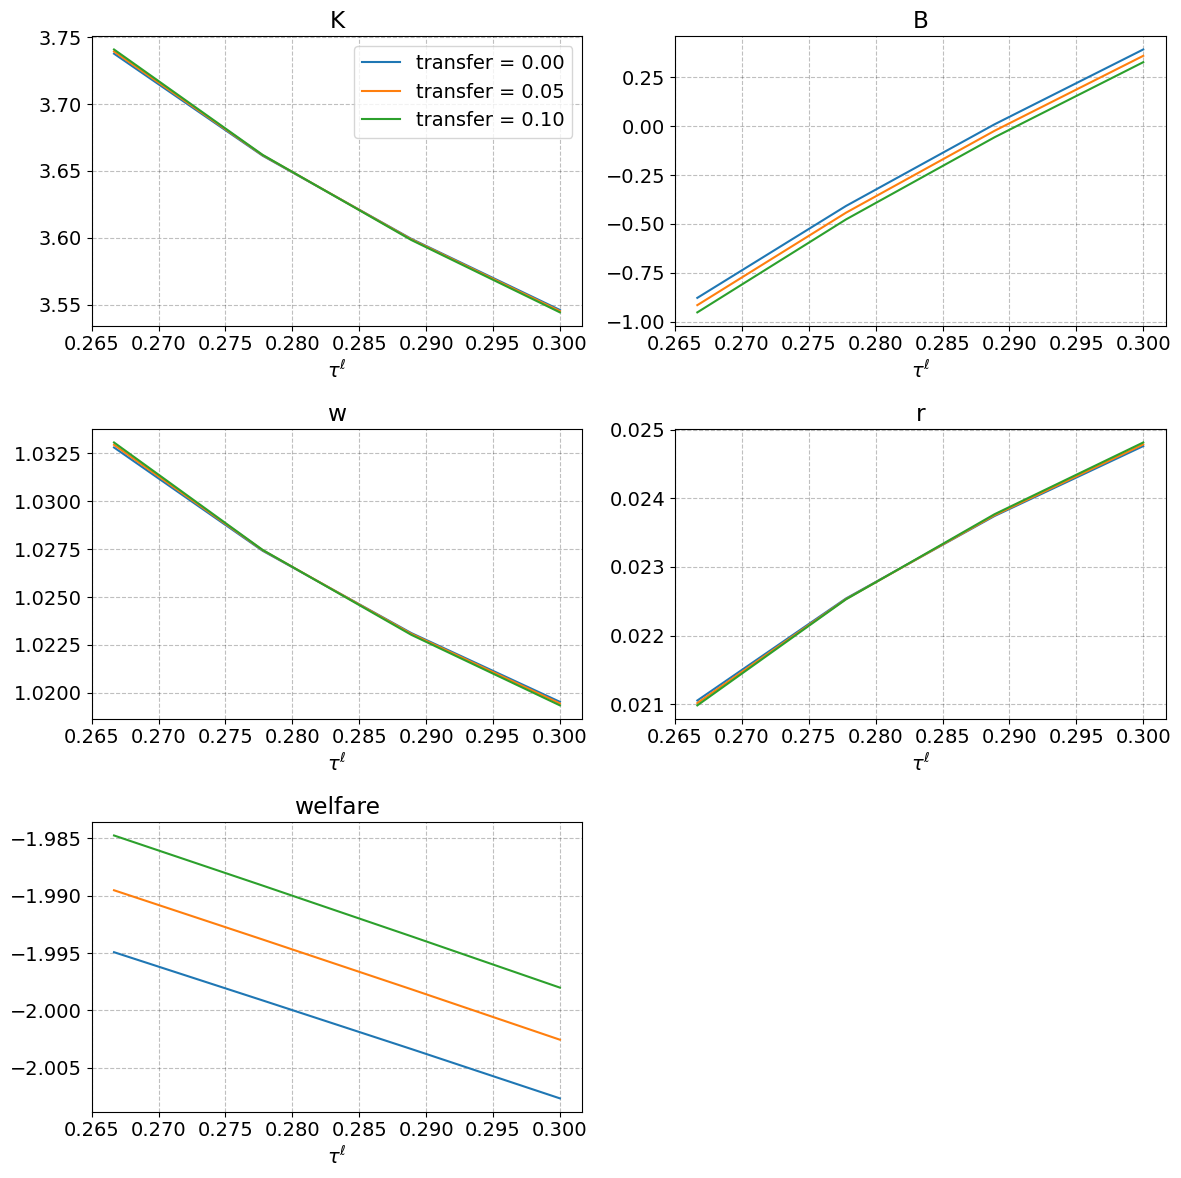

In [20]:
fig = plt.figure(figsize=(12,12),dpi=100)

# a. income
ax1 = fig.add_subplot(3,2,1)
ax1.set_title('K')

ax2 = fig.add_subplot(3,2,2)
ax2.set_title('B')

ax3 = fig.add_subplot(3,2,3)
ax3.set_title('w')

ax4 = fig.add_subplot(3,2,4)
ax4.set_title('r')

ax5 = fig.add_subplot(3,2,5)
ax5.set_title('welfare')

for transfer in transfer_vec:
    
    x = []
    y1 = []
    y2 = []
    y3 = []
    y4 = []
    y5 = []
    y6 = []
    
    for tau_ell in tau_ell_vec:
        key = (transfer,tau_ell)
        if key in models_transfers:
            x.append(tau_ell)    
            y1.append(models_transfers[key].ss.K)
            y2.append(models_transfers[key].ss.B)
            y3.append(models_transfers[key].ss.w)
            y4.append(models_transfers[key].ss.r)
            y5.append(models_transfers[key].ss.U_hh)
    
    if len(y1) > 0: ax1.plot(x,y1,label=f'{transfer = :.2f}')
    if len(y2) > 0: ax2.plot(x,y2,label=f'{transfer = :.2f}')
    if len(y3) > 0: ax3.plot(x,y3,label=f'{transfer = :.2f}')        
    if len(y4) > 0: ax4.plot(x,y4,label=f'{transfer = :.2f}') 
    if len(y5) > 0: ax5.plot(x,y5,label=f'{transfer = :.2f}') 
    
for ax in [ax1,ax2,ax3,ax4,ax5]:
    ax.set_xlabel('$\\tau^{\ell}$')
        
ax1.legend(frameon=True)
fig.tight_layout()

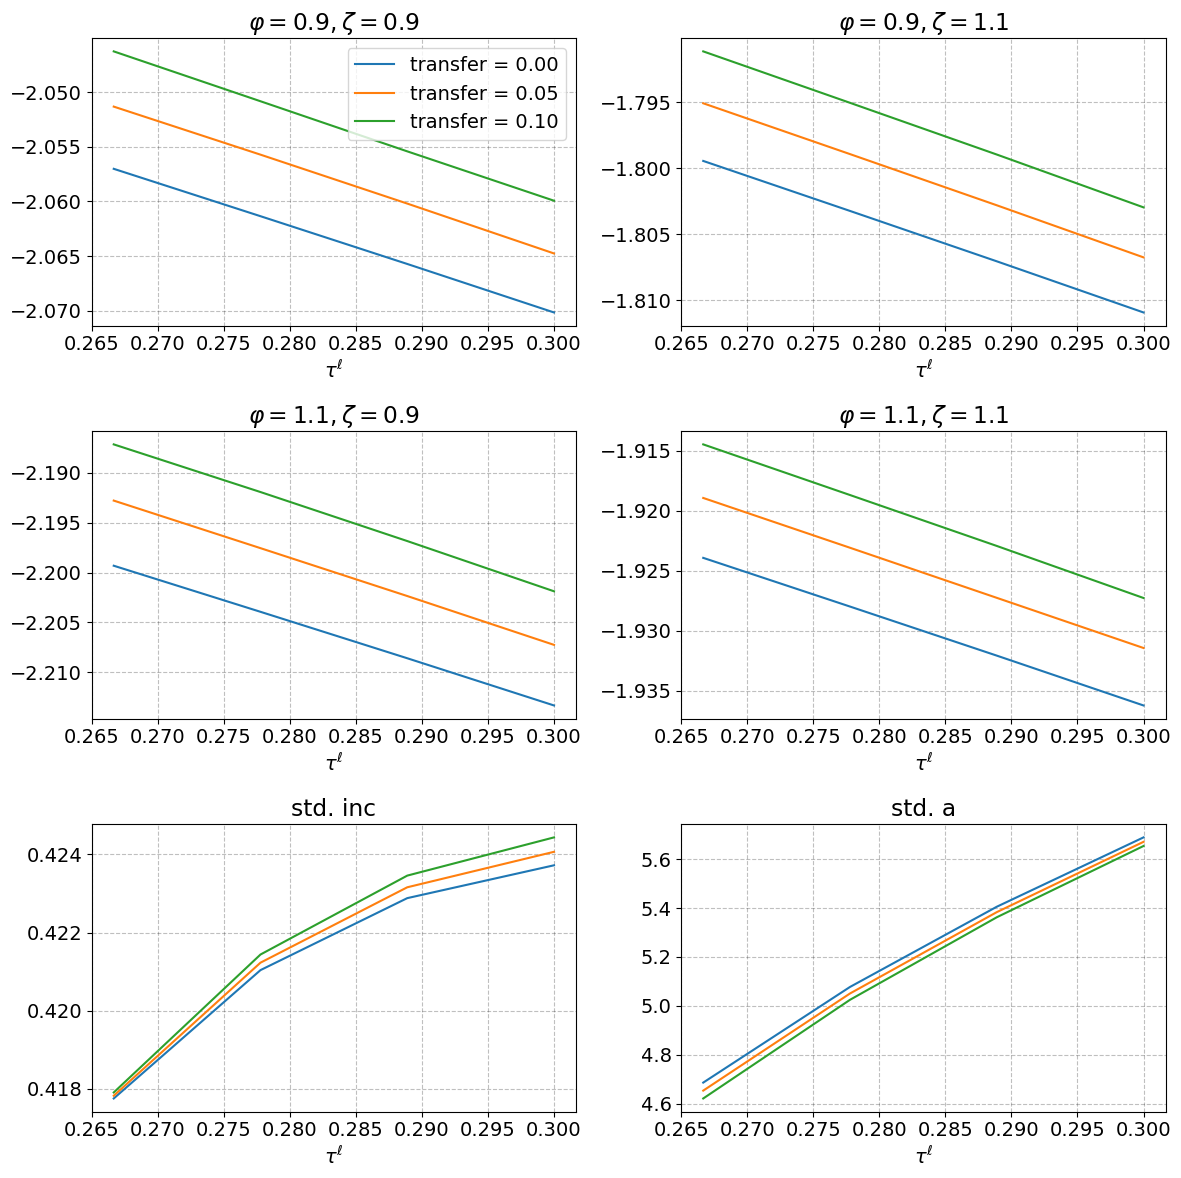

In [21]:
fig = plt.figure(figsize=(12,12),dpi=100)

axs = []
for i_fix in range(par.Nfix+2):

    ax = fig.add_subplot(3,2,1+i_fix)
    
    if i_fix == par.Nfix:
        ax.set_title(f'std. inc')
    elif i_fix == par.Nfix+1:
        ax.set_title(f'std. a')
    else:
        ax.set_title(f'$\\varphi = {par.varphi_grid[i_fix]}, \\zeta = {par.zeta_grid[i_fix]}$')

    axs.append(ax)

for transfer in transfer_vec:
    
    x = []
    
    y1 = []
    y2 = []
    y3 = []
    y4 = []
    y5 = []
    y6 = []

    for tau_ell in tau_ell_vec:
        key = (transfer,tau_ell)
        if key in models_transfers:
            x.append(tau_ell)    
            y1.append(models_transfers[key].ss.U_hh_0)
            y2.append(models_transfers[key].ss.U_hh_1)
            y3.append(models_transfers[key].ss.U_hh_2)
            y4.append(models_transfers[key].ss.U_hh_3)
            y5.append(models_transfers[key].ss.std_inc)
            y6.append(models_transfers[key].ss.std_a)

    if len(y1) > 0: axs[0].plot(x,y1,label=f'transfer = {transfer:.2f}')
    if len(y2) > 0: axs[1].plot(x,y2,label=f'transfer = {transfer:.2f}')
    if len(y3) > 0: axs[2].plot(x,y3,label=f'transfer = {transfer:.2f}')       
    if len(y4) > 0: axs[3].plot(x,y4,label=f'transfer = {transfer:.2f}')
    if len(y5) > 0: axs[4].plot(x,y5,label=f'transfer = {transfer:.2f}')
    if len(y6) > 0: axs[5].plot(x,y6,label=f'transfer = {transfer:.2f}')
    
for ax in axs:
    ax.set_xlabel('$\\tau^{\ell}$')
        
axs[0].legend(frameon=True)
fig.tight_layout()